# An exploration of visual concept learning by example of a variational autoencoder (VAE)
Practical part to the exam in Cognition and Computation, University of Padova, 2025-01-12.
## Author
Frederik Dammeier

`frederik.dammeier@studenti.unipd.it`

2169606

# Dataset

We select as the dataset for the following experiments the **Fruits and Vegetables Image Recognition Dataset** publicly available on Kaggle: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

This dataset contains **36 classes** of different fruits and vegetables distributed across a train-val-test split. The base images are of varying sizes and too big for the following experiments, so we resize them ahead of the modeling pipeline.


# Download data
For this series of experiments, we use a version of the original dataset that is resized and squared to 64*64 images. It is provided alongside the code for the model on the project Github: https://github.com/frederikdammeier/unipd-cognition-computation

In [76]:
%%capture
!mkdir data
!wget -O data/fruits-vegetables-resized64.zip "https://github.com/frederikdammeier/unipd-cognition-computation/blob/main/data/fruits-vegetables-resized64.zip?raw=true"
!unzip data/fruits-vegetables-resized64.zip -d data/

# Additional code
We have externalized some Python classes and functions to seperate files that we download from the associated github repository.

In [11]:
def get_codefiles():
  !mkdir src
  files = ["src/data.py", "src/vision_vae.py", "src/vision_classifier.py", "src/utils.py", "train_vae.py"]
  repository_url = "https://raw.githubusercontent.com/frederikdammeier/unipd-cognition-computation/main/"
  for file in files:
    !wget -O {file} {repository_url}{file}

In [14]:
%%capture
get_codefiles()

# Load dependencies

In [1]:
# For debugging and easier development.
from src.data import ImageDataLoader, ImageDataset
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from src.vision_vae import VisionVAE, IntermediateActivationCapture
from train_vae import train_vae
import torch
from src.utils import visualize_activation_maps

# Set seed for reproducibility
seed = 4096
torch.manual_seed(seed)
numpy_rng = np.random.default_rng(seed)

# Dataset and DataLoader
We provide simple Pytorch Dataset and DataLoader classes to deal with the image dataset. Ahead of training, we can use it to display a batch of sample images from the dataset, and to calculate dataset statistics.


In [2]:
# Create the training DL and extract the dataset
train_dl = ImageDataLoader.create_dataloader("./data/resized64/versions/8/train")
train_ds = train_dl.dataset

print(f"Number of training samples: {len(train_ds)}")

Number of training samples: 2847


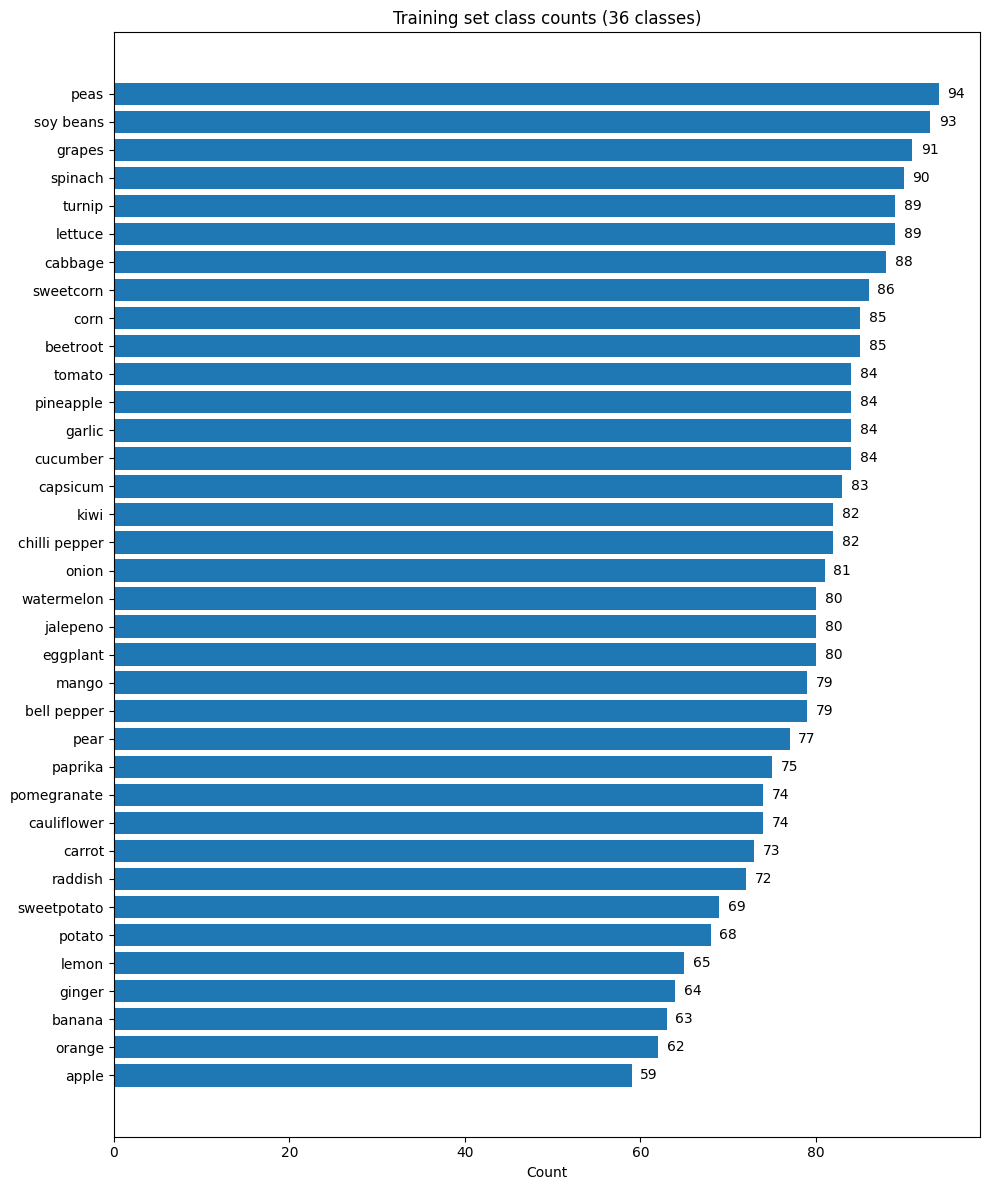

In [3]:
# Class statistics
labels = train_ds.labels
idx_to_class = train_ds.idx_to_class

import matplotlib.pyplot as plt

counts = Counter(labels)
class_indices = sorted(idx_to_class.keys())
class_names = [idx_to_class[i] for i in class_indices]
class_counts = [counts.get(i, 0) for i in class_indices]

# sort by count (descending) for better readability
sorted_pairs = sorted(zip(class_counts, class_names), reverse=True)
counts_sorted, names_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10, 12))
y_pos = np.arange(len(names_sorted))
plt.barh(y_pos, counts_sorted, color='tab:blue')
plt.yticks(y_pos, names_sorted)
plt.gca().invert_yaxis()  # largest on top
plt.xlabel('Count')
plt.title(f'Training set class counts ({len(counts)} classes)')
# annotate counts
max_count = max(counts_sorted) if counts_sorted else 0
for i, v in enumerate(counts_sorted):
    plt.text(v + max(1, max_count * 0.01), i, str(v), va='center')
plt.tight_layout()
plt.show()

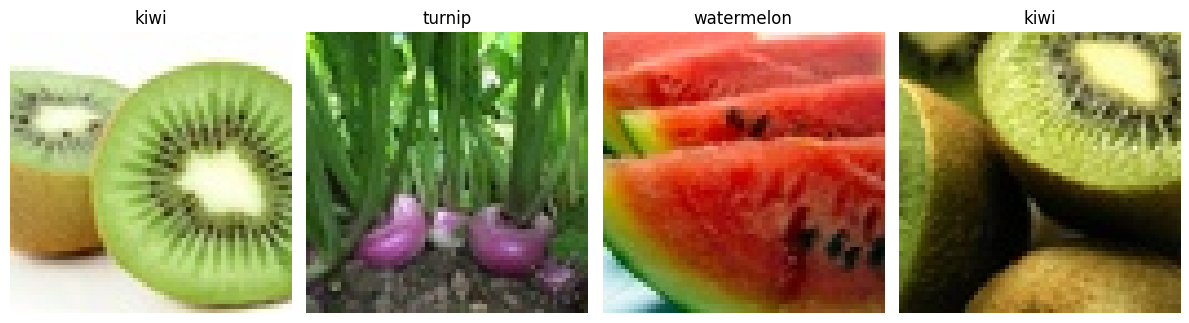

In [4]:
# Randomly select a batch of size n from the training dataset
n = 4  # batch size
n_samples = len(train_ds)
indices = numpy_rng.choice(n_samples, size=n, replace=False)

# Get batch from train_ds
imgs = torch.stack([train_ds[i][0] for i in indices])
targets = torch.tensor([train_ds[i][1] for i in indices])

plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs):
    pil = ToPILImage()(img.cpu())
    plt.subplot(1, 4, i + 1)
    plt.imshow(pil)
    plt.axis('off')
    title = idx_to_class.get(int(targets[i]), '') if targets[i] is not None else ''
    plt.title(title)
plt.tight_layout()
plt.show()

# Model
We chose as our model of exploration a variational autoencoder (VAE). The VAE, first introduced by D.P. Kingma and M. Welling in 2013 is a computational framework for usupervised learning of data distributions. While deriving its name from traditional autoencoder networks that use a bottleneck within a deep neural network to learn a low-dimensional representation of the data, VAEs actually model the data distrubution directly which enables the generation of new (unseen) samples from the learnt data distribution once the model is trained. This places the VAE as a prominent example of the larger family of generative neural network architectures.

A thorough introduction to VAEs is out of scope of this work. Importantly, VAEs apply a variety of mathematical tricks to arrive at an estimation of the data probability distribution _Pr(X)_. One of these is the variational approximation of _Pr(X)_ by a lower-dimensional latent distribution _Pr(Z|X)_ which gives the VAE its name. Another is the use of the **ELBO**, the lower bound to the evidence (of the data), as the loss function during training, which can be phrased as dependent on both the encoder and decoder parameters. In its most practical and widely used from, `ELBO = reconstruction_error - variational_divergence`, the ELBO is easily integrated into the training pipeline and allows to put a weight on the factors. Usually, the variational divergence (Kullbach-Leibacher divergence between latent prior and posterior) is weighted by a factor of beta (beta-VAE, Higgings et al. 2017) which allows to emphasize the structure of the latent representation during training.

Higgings et al. and later authors show that under certain assumptions and parametrizations, VAEs are capable of disentangling features of the data-space in their latent representations.

## Architecture
We construct a simple vision VAE based on convolutional layers.

In [5]:
latent_dim = 64
beta = 1.0
beta_norm = beta / ((64 * 64 * 3) / latent_dim) # normalize beta based on input and latent size (empirical insight)

vae = VisionVAE(latent_dim=latent_dim, beta=beta_norm)

print(vae)

trainable_params = sum(
    p.numel() for p in vae.parameters() if p.requires_grad
)

print(f"Trainable parameters: {trainable_params}")

VisionVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4096, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=4096, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Trainable parameters: 2170691


We use four convolutional layers for the encoder and decoder respectively, employing stride to reduce the size of the feature map with each step. The resulting linear layer is of size 4096 and is used to learn the mean and log-variance of the Gaussian latent space posterior.

We use a classic implementation of the ELBO including beta:
```python 
# Reconstruction loss
recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')

# KL divergence loss
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

# Total loss with beta weighting
loss = recon_loss + self.beta * kl_loss
```
The formulation of the KL-divergence ensures that the model is encouraged to map the data distribution to a Gaussian distribution with 0 mean and unit variance, thus encouraging disentangled features (no covariance).

## Training
We provide an externalized train script `train_vae.py` which will be imported into this notebook for documentation purposes. Besides the standard training parameters like batch size and learning rate, we implement the following particularities:

- Beta normalization. The input beta is normalized by input size (W*H*C) and latent_dim following literature insight (e.g. Higgings et al. 2017): `beta_norm = beta / ((64 * 64 * 3) / latent_dim)`
- Transforms. We apply random horizontal flipping as an augmentation strategy.
- Optimizer. We use a standard Adams optimizer.
- Logging. We use Weights and Biases (https://wandb.ai) to track our training runs. This is optional and will not be active unless logged in.

The choice of the dataset and model sizes is such that it can be conveniently trained on moderate hardware. On a MacBook Air M3, training of a single model for 50 epochs takes about 5 minutes.


In [6]:
data_root = "./data/resized64/versions/8/train"
batch_size = 32
num_epochs = 50
learning_rate = 1e-3
latent_dim = 64
beta = 5.0 # we found the training to be quite robust to small changes in beta. Similar results are obtained for beta = 1.0.
num_workers = 0
use_wandb = False

train_vae(data_root=data_root,
          batch_size=batch_size,
          num_epochs=num_epochs,
          learning_rate=learning_rate,
          latent_dim=latent_dim,
          beta=beta,
          num_workers=num_workers,
          use_wandb=use_wandb)

Using device: cpu
Normalized beta: 0.026041666666666668
Loading data from ./data/resized64/versions/8/train
Loaded 2847 images
Created VisionVAE with latent_dim=64, beta=0.026041666666666668

Starting training for 50 epochs...
Epoch [1/50] Loss: 0.6700 (Recon: 0.6696, KL: 0.0133)
Epoch [2/50] Loss: 0.5732 (Recon: 0.5720, KL: 0.0487)
Epoch [3/50] Loss: 0.5469 (Recon: 0.5452, KL: 0.0648)
Epoch [4/50] Loss: 0.5364 (Recon: 0.5346, KL: 0.0698)
Epoch [5/50] Loss: 0.5313 (Recon: 0.5294, KL: 0.0715)
Epoch [6/50] Loss: 0.5266 (Recon: 0.5247, KL: 0.0737)
Epoch [7/50] Loss: 0.5225 (Recon: 0.5205, KL: 0.0748)
Epoch [8/50] Loss: 0.5190 (Recon: 0.5170, KL: 0.0781)
Epoch [9/50] Loss: 0.5158 (Recon: 0.5138, KL: 0.0778)
Epoch [10/50] Loss: 0.5149 (Recon: 0.5129, KL: 0.0770)
Saved checkpoint to checkpoints/vae_epoch_10.pt
Epoch [11/50] Loss: 0.5120 (Recon: 0.5099, KL: 0.0793)
Epoch [12/50] Loss: 0.5101 (Recon: 0.5080, KL: 0.0795)
Epoch [13/50] Loss: 0.5084 (Recon: 0.5063, KL: 0.0799)
Epoch [14/50] Loss:

In [7]:
# we now use our previously instantiated VAE to load the trained weights:
vae.load_state_dict(torch.load("checkpoints/vae_final.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = vae.to(device)

# Analysis of the trained model

## Reconstruction examples
We start by simply viewing a few side by side ground-truth vs reconstructed examples from the validataion set

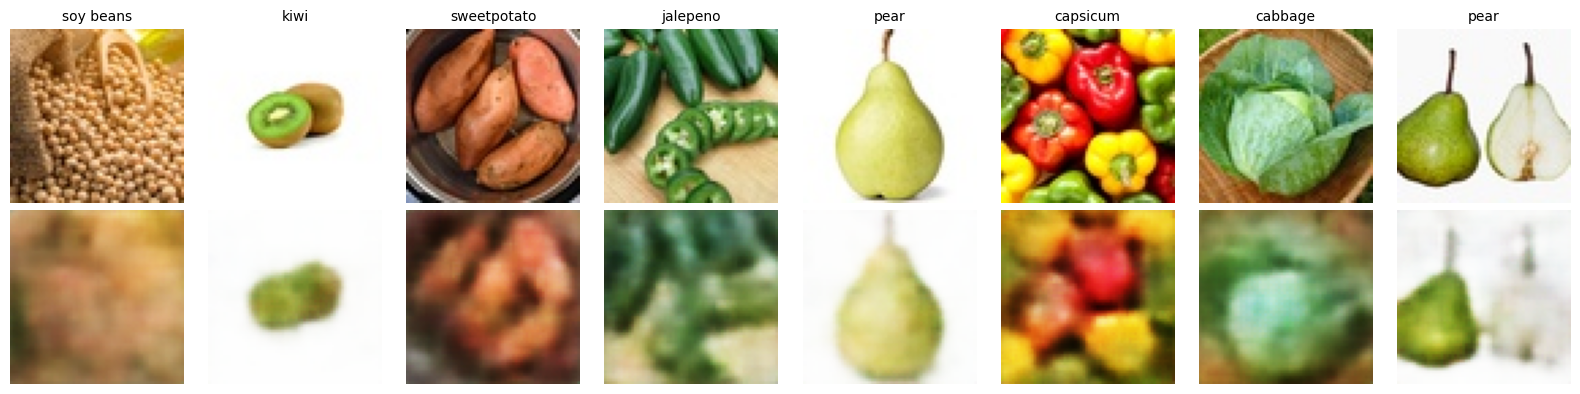

In [8]:
# Create a dataloader and dataset for the validation set
val_dl = ImageDataLoader.create_dataloader("./data/resized64/versions/8/validation", batch_size=32, shuffle=False)
val_ds = val_dl.dataset

# Manually sample a small batch from the validation dataset for reproducability
n_val_samples = len(val_ds)
n = 8  # batch size for visualization
val_indices = numpy_rng.choice(n_val_samples, size=n, replace=False)

imgs = torch.stack([val_ds[i][0] for i in val_indices])
targets = torch.tensor([val_ds[i][1] for i in val_indices])

imgs = imgs.to(device)

with torch.no_grad():
    reconstructed_imgs, _, _, _ = vae(imgs)

# move tensors to cpu for visualization
reconstructed_imgs = reconstructed_imgs.cpu()
imgs_cpu = imgs.cpu()

# plot grid: 2 rows x 8 columns (first row: ground truth, second row: reconstructions)
n_cols = 8
fig, axs = plt.subplots(2, n_cols, figsize=(16, 4))
for col in range(n_cols):
    # original
    orig_pil = ToPILImage()(imgs_cpu[col])
    axs[0, col].imshow(orig_pil)
    axs[0, col].axis('off')
    # reconstructed
    recon_pil = ToPILImage()(reconstructed_imgs[col])
    axs[1, col].imshow(recon_pil)
    axs[1, col].axis('off')
    # label column by class (on the top subplot)
    cls_name = idx_to_class.get(int(targets[col]), '') if targets is not None else ''
    axs[0, col].set_title(cls_name, fontsize=10)

plt.tight_layout()
plt.show()

Note that the model itself is not aware of the categories in the dataset. Those are purely added for context in the visualization. It can be observed that the general visual structures of the images are captured well by the model, although the reconstructed images are smoothed and small details vanish. This is a common challenge with VAEs and is usually overcome using hierarchical latents (as, for example, in diffusion models). Particular to our choice of deconvolution in the decoder network is the grainy apprearance of the reconstructed samples. Smoother versions can be achieved using upsampling and standard convolution, but this proved to be way slower in our setup so we decided to stick to `ConvTranspose2d`.

## Visualization of latent and intermediate representations
In this section, we have a look into the feature maps of the encoder and decoder, and analize the latent representation. We define a helper class to capture the intermediate activations between the layers and visualize them according to the model hierarchy. We visualize the same 8 samples as before.

In [9]:
capturer = IntermediateActivationCapture(vae)
results = capturer.capture_inference(imgs, device='cpu')
capturer.remove_hooks()

### Encoder Conv1

The first convolutional layer results in 32 feature maps of size 32*32. Let's visualize a couple. 

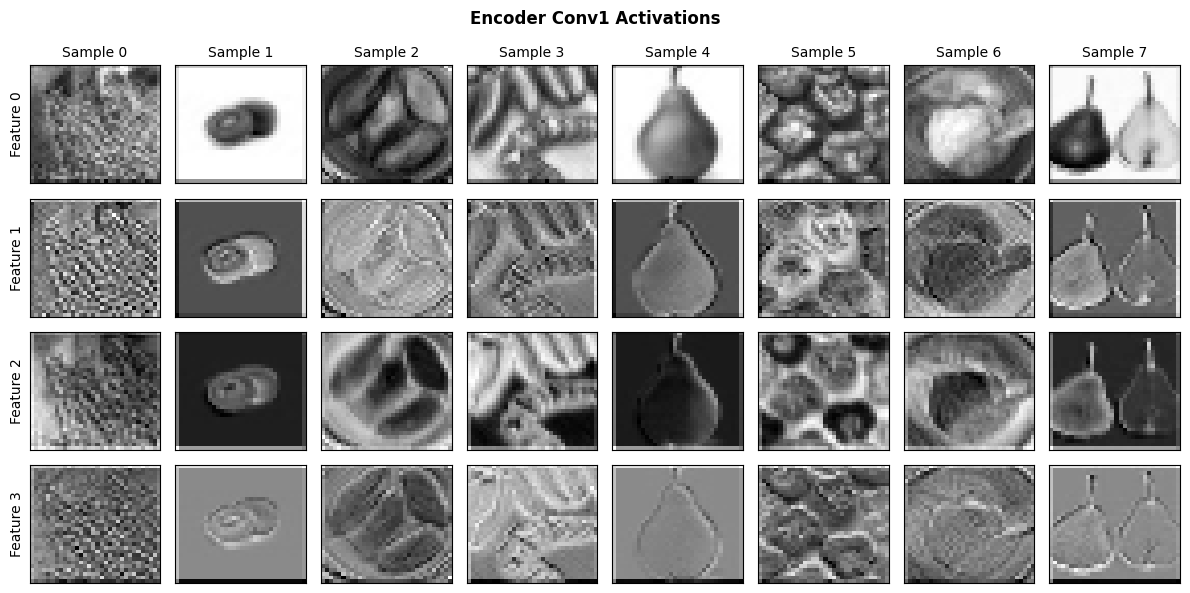

In [10]:
from src.utils import visualize_activation_maps

# Visualize first 8 feature maps
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv1"], n_maps=4, cmap='gray', title="Encoder Conv1 Activations")
plt.show()

### Encoder Conv2

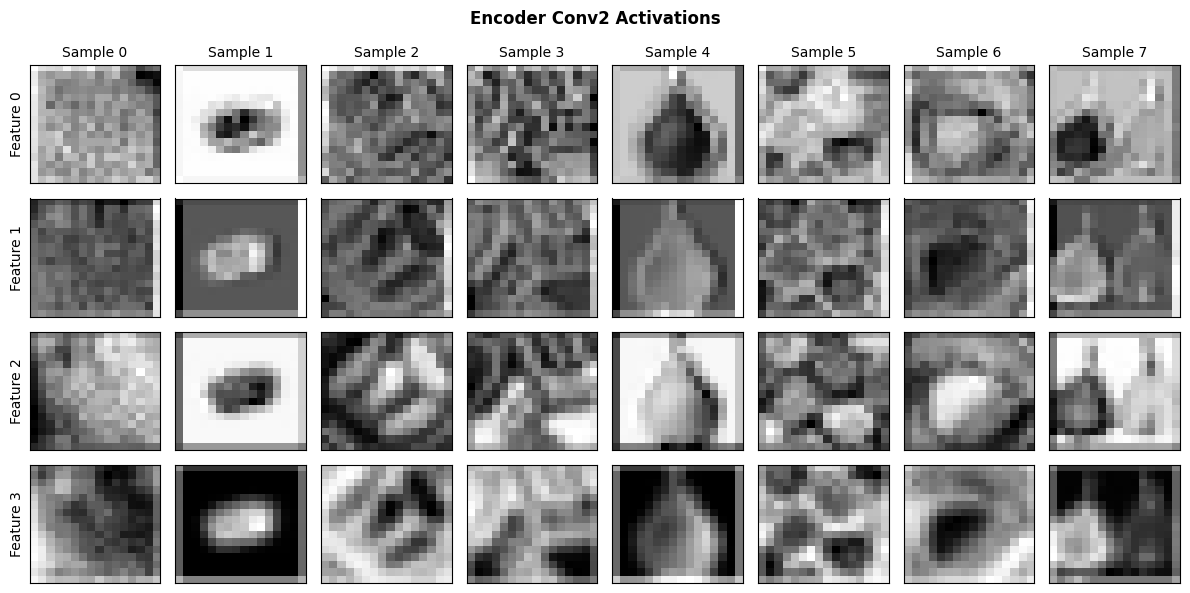

In [11]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv2"], n_maps=4, cmap='gray', title="Encoder Conv2 Activations")
plt.show()

### Encoder Conv3

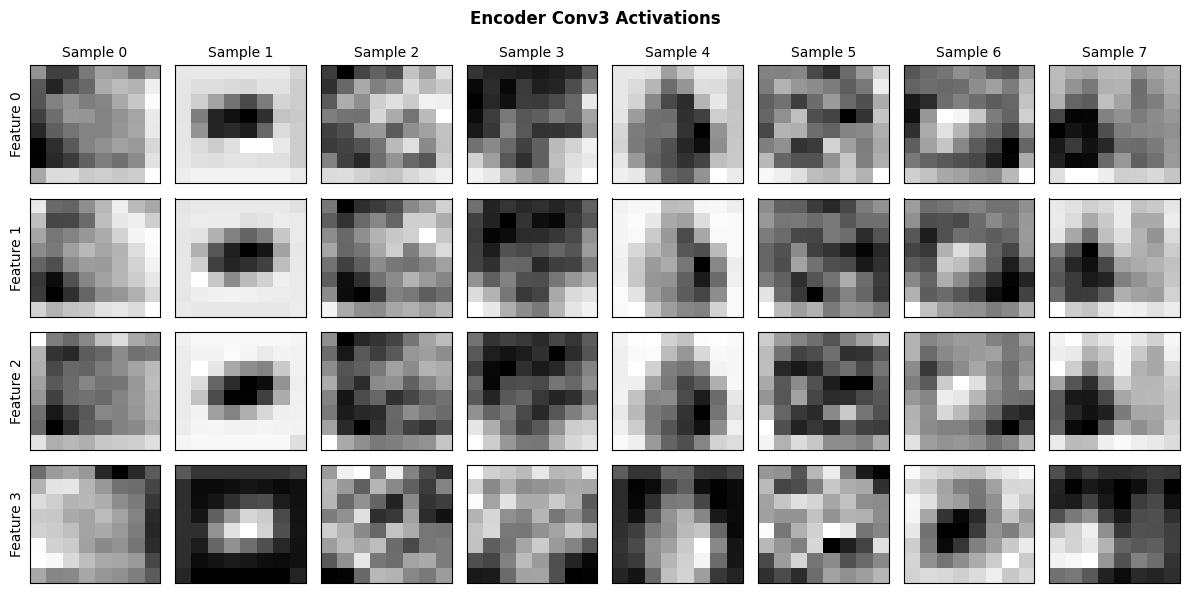

In [12]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv3"], n_maps=4, cmap='gray', title="Encoder Conv3 Activations")
plt.show()

### Encoder Conv4

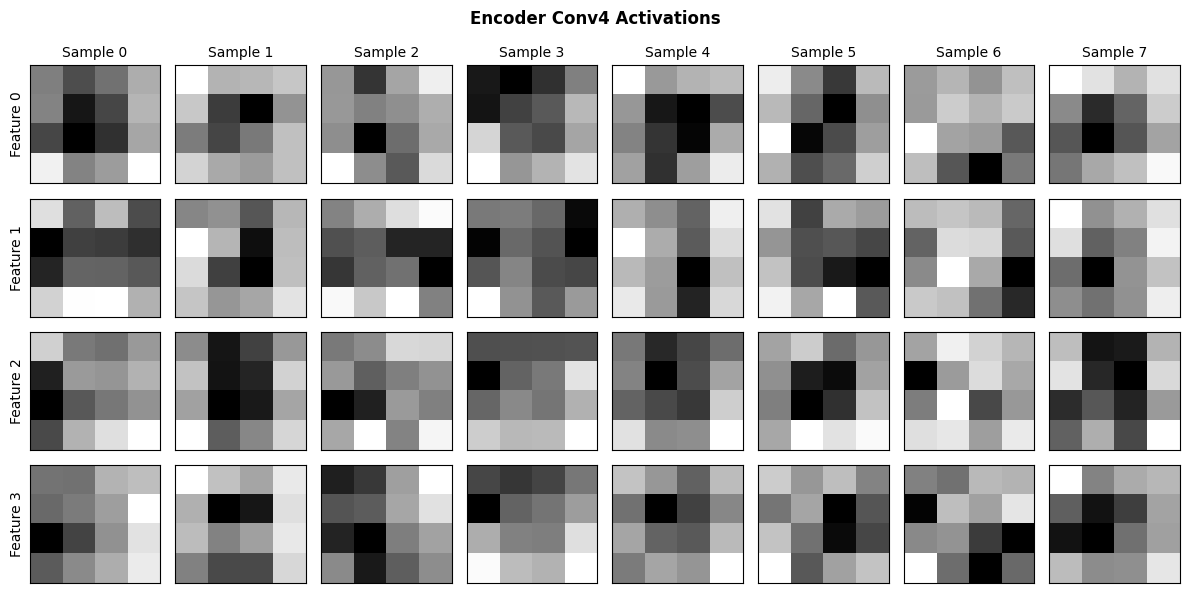

In [13]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv4"], n_maps=4, cmap='gray', title="Encoder Conv4 Activations")
plt.show()

### Latent representation z

Latent representations in the VAE are composed of mean and logvar variance vectors of the latent distribution. In our example, we plot the mean values to see if we spot any patterns in the activations.

We follow up with a class-based analysis later.

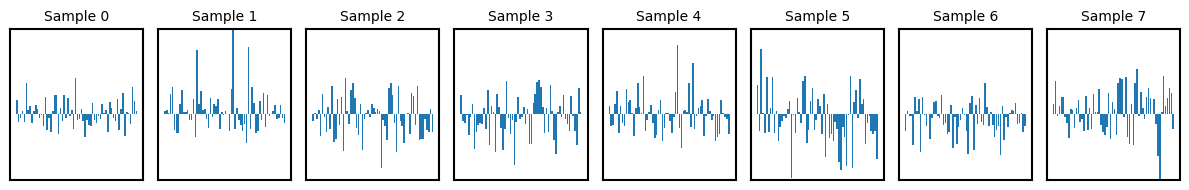

In [14]:
def plot_latent_vectors(z, figsize=None):
    z_np = z.detach().cpu().numpy() if isinstance(z, torch.Tensor) else z
    fig, axes = plt.subplots(1, z_np.shape[0], figsize=figsize or (z_np.shape[0]*1.5, 2))
    axes = [axes] if z_np.shape[0] == 1 else axes
    vmin, vmax = z_np.min(), z_np.max()
    for i, (ax, row) in enumerate(zip(axes, z_np)):
        ax.bar(range(z_np.shape[1]), row)
        ax.set_ylim(vmin, vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Sample {i}', fontsize=10)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
    plt.tight_layout()

plot_latent_vectors(results["encoder_activations"]["encoder_fc_mu"])

### Decoder Deconv1

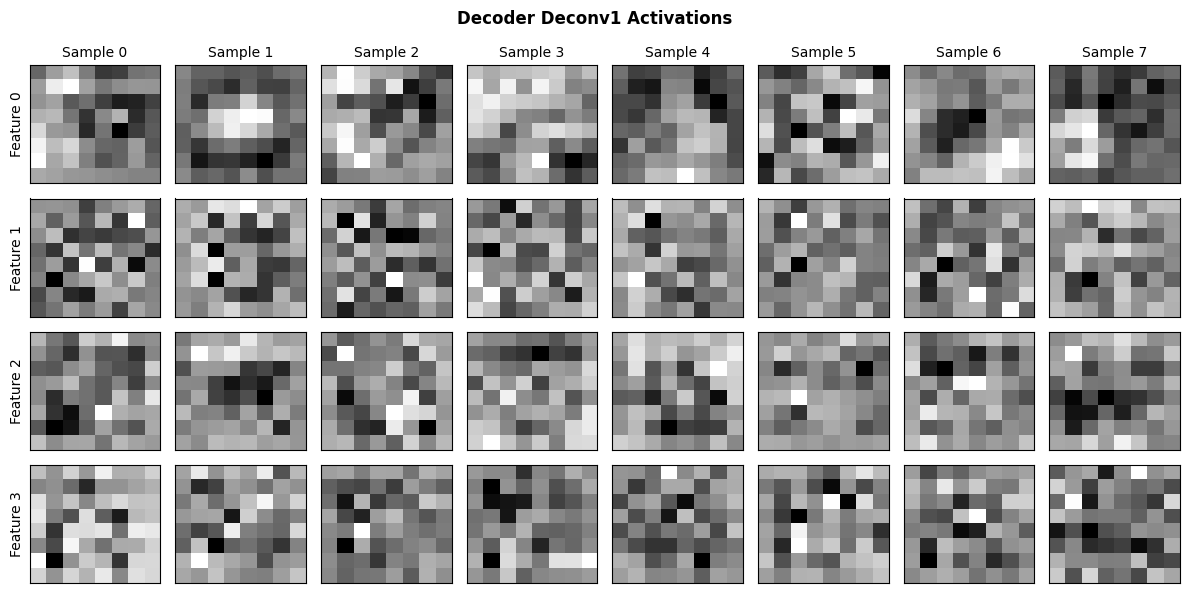

In [15]:

fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv1"], n_maps=4, cmap='gray', title="Decoder Deconv1 Activations")
plt.show()

### Decoder Deconv2

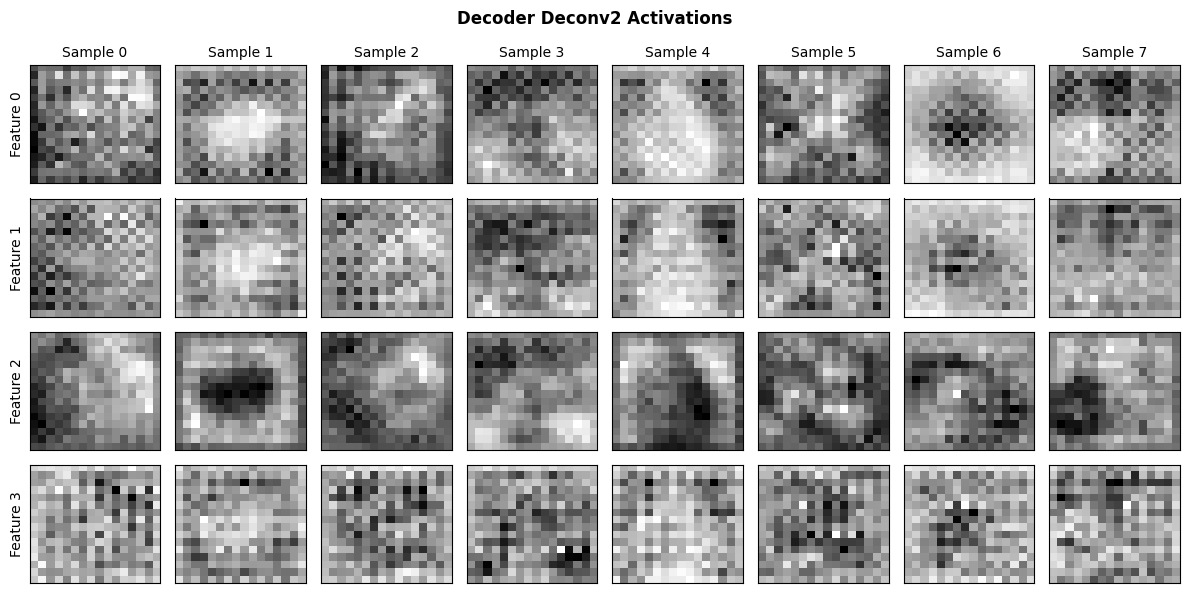

In [16]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv2"], n_maps=4, cmap='gray', title="Decoder Deconv2 Activations")
plt.show()

### Decoder Deconv3

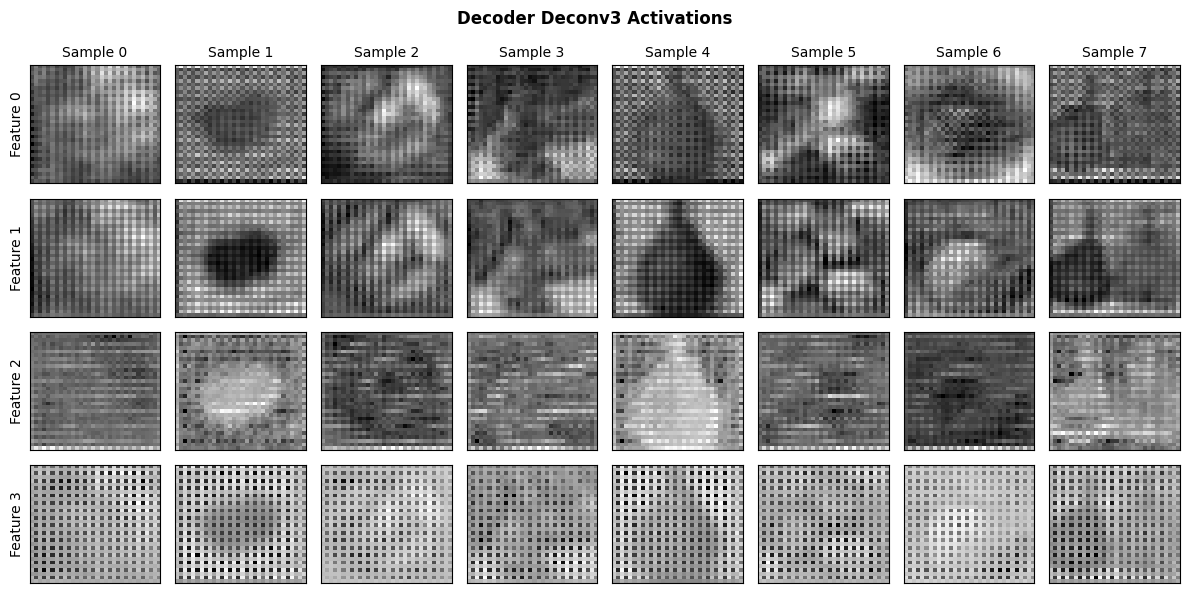

In [17]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv3"], n_maps=4, cmap='gray', title="Decoder Deconv3 Activations")
plt.show()

### Decoder Deconv4
These correspond to the three color channels RGB of the reconstructed images.

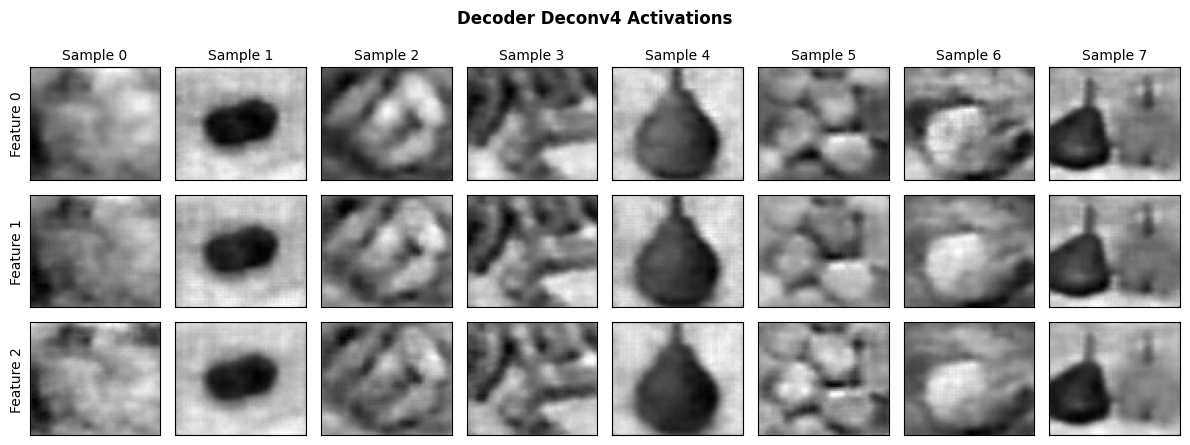

In [18]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv4"], n_maps=4, cmap='gray', title="Decoder Deconv4 Activations")
plt.show()

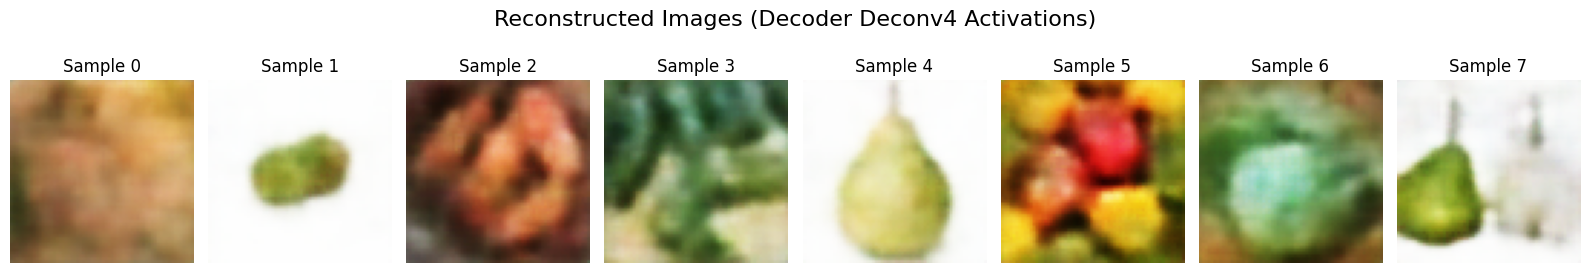

In [19]:

n_cols = 8
fig, axs = plt.subplots(1, n_cols, figsize=(16, 3))
for col in range(n_cols):
    # reconstructed
    recon_pil = ToPILImage()(reconstructed_imgs[col])
    axs[col].imshow(recon_pil)
    axs[col].axis('off')
    # label column by class (on the top subplot)
    cls_name = [f"Sample {i}" for i in range(n_cols)][col]
    axs[col].set_title(cls_name, fontsize=12)

fig.suptitle("Reconstructed Images (Decoder Deconv4 Activations)", fontsize=16)

plt.tight_layout()
plt.show()

# Hierarchical clustering of latent representations

We follow the approach from the lab to obtain a dendrogram of the class centroids of the latent means.
Experiments have shown that we can easily obtain intermediate activations for the entire training set and every layer in a single pass. We perform capturing on both the train and test set for the linear readouts lateron.


In [20]:
def capture_all_activations(vae, dataset, device):
    imgs = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)
    labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)

    capturer = IntermediateActivationCapture(vae)
    results = capturer.capture_inference(imgs, device=device)
    capturer.remove_hooks()
    return results, labels

train_cts, train_labels = capture_all_activations(vae, train_ds, device)
val_cts, val_labels = capture_all_activations(vae, val_ds, device)

In [21]:
# extract all latent means from training set activations
all_mu = train_cts["encoder_activations"]["encoder_fc_mu"]

unique_labels = torch.unique(train_labels, sorted=True)
class_centroids = torch.stack([all_mu[train_labels == l].mean(dim=0) for l in unique_labels], dim=0)

print(f"class_centroids shape: {class_centroids.shape}")  

class_centroids shape: torch.Size([36, 64])


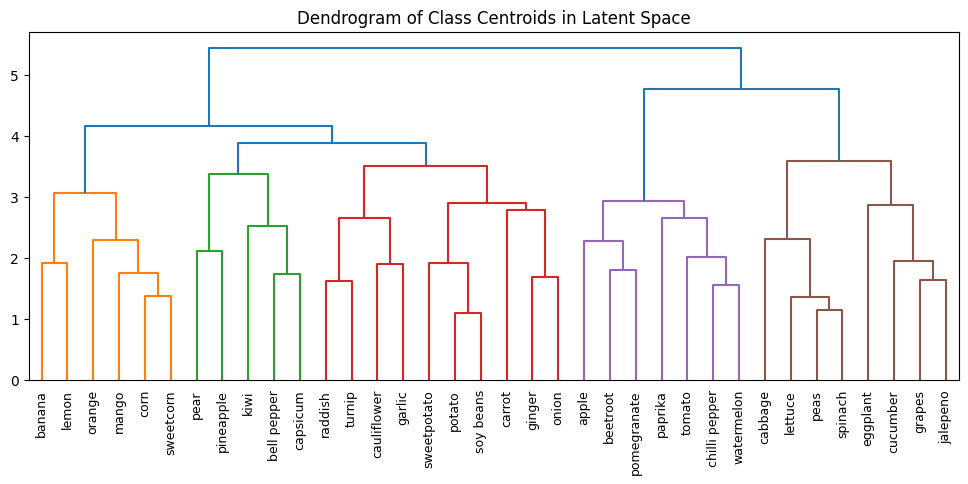

In [22]:
import scipy.cluster as cluster

def plot_dendrogram(mean_repr_matrix, title=""):
    fig, ax = plt.subplots(figsize=(12, 6))
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage, labels=[train_ds.idx_to_class[int(l.item())] for l in unique_labels])
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize=9)
    fig.subplots_adjust(bottom=0.3)
    ax.set_title(title)

plot_dendrogram(class_centroids.numpy(), title="Dendrogram of Class Centroids in Latent Space")

We can observe a very strong clustering by color and a weaker clustering by form of the plant.

# Linear readout
 Similar to the first lab, we perform linear classification of selected intermediate representations to evalutate the information contained in the various latent representations related to the class label.

In [23]:
class LinearModel(torch.nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(layer_size, 36)

    def forward(self, x):
        return self.linear(x)
  
def train_linear(linear, hidden_reprs, labels, device, lr=1, epochs=5000, verbose=True):
    optimizer = torch.optim.SGD(linear.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    hidden_reprs.to(device)
    labels.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = linear(hidden_reprs).squeeze()
        targets = labels
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if verbose:
            if epoch % 100 == 0:
                print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

We define a loop that performs training and evaluation of linear models across all encoder layers.

In [24]:
# Recycled method from lecture
def compute_accuracy(predictions_test, targets):
    predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

In [25]:
layers = ["encoder_conv1", "encoder_conv2", "encoder_conv3", "encoder_conv4"]

models = {}
accuracies = {}

def evaluate_layer(layer_activations, val_activations):    # Training
    linear_model = LinearModel(layer_size=layer_activations.shape[1]).to(device)
    train_linear(linear_model, layer_activations, train_labels, device, lr=1, epochs=20000, verbose=False)

    # Evaluation on validation set
    with torch.no_grad():
        val_pred = linear_model(val_activations).squeeze()

    return linear_model, val_pred, compute_accuracy(val_pred, val_labels)

# Evaluate conv layers with global average pooling
for layer in layers:
    encoder_activations = train_cts["encoder_activations"][layer].mean(dim=[2, 3]) # global average pooling
    val_activations = val_cts["encoder_activations"][layer].mean(dim=[2, 3])

    # Training & Evaluation
    print(f"Training and evaluating linear model on {layer} activations of shape: {encoder_activations.shape}")
    models[layer], _, accuracies[layer] = evaluate_layer(encoder_activations, val_activations)

# Evaluate latent space (fc_mu)
encoder_fc_mu_activations = train_cts["encoder_activations"]["encoder_fc_mu"]
val_fc_mu_activations = val_cts["encoder_activations"]["encoder_fc_mu"]

print(f"Training and evaluating linear model on encoder_fc_mu activations of shape: {encoder_fc_mu_activations.shape}")
# store model for later use
models["latent_means"], val_preds_mu, accuracies["latent_means"] = evaluate_layer(encoder_fc_mu_activations, val_fc_mu_activations)

for layer, acc in accuracies.items():
    print(f"Validation accuracy using {layer} activations: {acc:.4f}")

Training and evaluating linear model on encoder_conv1 activations of shape: torch.Size([2847, 32])
Training and evaluating linear model on encoder_conv2 activations of shape: torch.Size([2847, 64])
Training and evaluating linear model on encoder_conv3 activations of shape: torch.Size([2847, 128])
Training and evaluating linear model on encoder_conv4 activations of shape: torch.Size([2847, 256])
Training and evaluating linear model on encoder_fc_mu activations of shape: torch.Size([2847, 64])
Validation accuracy using encoder_conv1 activations: 0.2382
Validation accuracy using encoder_conv2 activations: 0.3382
Validation accuracy using encoder_conv3 activations: 0.4353
Validation accuracy using encoder_conv4 activations: 0.4265
Validation accuracy using latent_means activations: 0.6000



We observe increasingly higher accuracy scores of the linear classifier as we advance down our model hierarchy, indicating that meaningful features are indeed extracted.  We acknowledge that our approach of average pooling on the convolutional layers might not be perfectly fair to each layer, but it is a simple and proved approach to reduce the dimensionality of convolutional outputs for downstream use. 

In [26]:
# also try a simple convolutional classifier on the original images
from src.vision_classifier import VisualClassifier, train_classifier

train_dl = ImageDataLoader.create_dataloader("./data/resized64/versions/8/train")
val_dl = ImageDataLoader.create_dataloader("./data/resized64/versions/8/validation")

vc = VisualClassifier(latent_dim=64, num_classes=len(train_dl.dataset.idx_to_class)).to(device)
results = train_classifier(vc, train_dl, val_dl, num_epochs=30, learning_rate=1e-3, device=device)

Epoch 1/30 - Train Loss: 3.4846, Train Acc: 0.0450, Val Loss: 3.1666, Val Acc: 0.0706
Epoch 2/30 - Train Loss: 3.2107, Train Acc: 0.0688, Val Loss: 2.9918, Val Acc: 0.1029
Epoch 3/30 - Train Loss: 3.0030, Train Acc: 0.1303, Val Loss: 2.6115, Val Acc: 0.2118
Epoch 4/30 - Train Loss: 2.7924, Train Acc: 0.1612, Val Loss: 2.4390, Val Acc: 0.2235
Epoch 5/30 - Train Loss: 2.6656, Train Acc: 0.2065, Val Loss: 2.1049, Val Acc: 0.3706
Epoch 6/30 - Train Loss: 2.4681, Train Acc: 0.2543, Val Loss: 1.9855, Val Acc: 0.3706
Epoch 7/30 - Train Loss: 2.3089, Train Acc: 0.2929, Val Loss: 1.7275, Val Acc: 0.4147
Epoch 8/30 - Train Loss: 2.1796, Train Acc: 0.3291, Val Loss: 1.7120, Val Acc: 0.4941
Epoch 9/30 - Train Loss: 2.0139, Train Acc: 0.3839, Val Loss: 1.4803, Val Acc: 0.5676
Epoch 10/30 - Train Loss: 1.9455, Train Acc: 0.4085, Val Loss: 1.4303, Val Acc: 0.5765
Epoch 11/30 - Train Loss: 1.8105, Train Acc: 0.4447, Val Loss: 1.1553, Val Acc: 0.6559
Epoch 12/30 - Train Loss: 1.6446, Train Acc: 0.4924,

In [27]:
dataset = val_ds

imgs = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)
labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)

with torch.no_grad():
    preds_vc = vc(imgs.to(device)).squeeze()

print(f"Validation accuracy using VisualClassifier on original images: {compute_accuracy(preds_vc.cpu(), labels):.4f}")

Validation accuracy using VisualClassifier on original images: 0.9529


We observe that a regular supervised model is much better in extracting class specific details from this dataset. We can only speculate why this is, but it seems likely that the VAE is not able to learn very robust generic features given the size (and diversity) of the dataset.

# Failure Modes

We now inspect the outputs from our best linear classifier (based on the latent mean vector) for noteable failure modes.

## Confusion Matrix

We start by visualizing a confusion matrix to spot classes that are not separated properly.

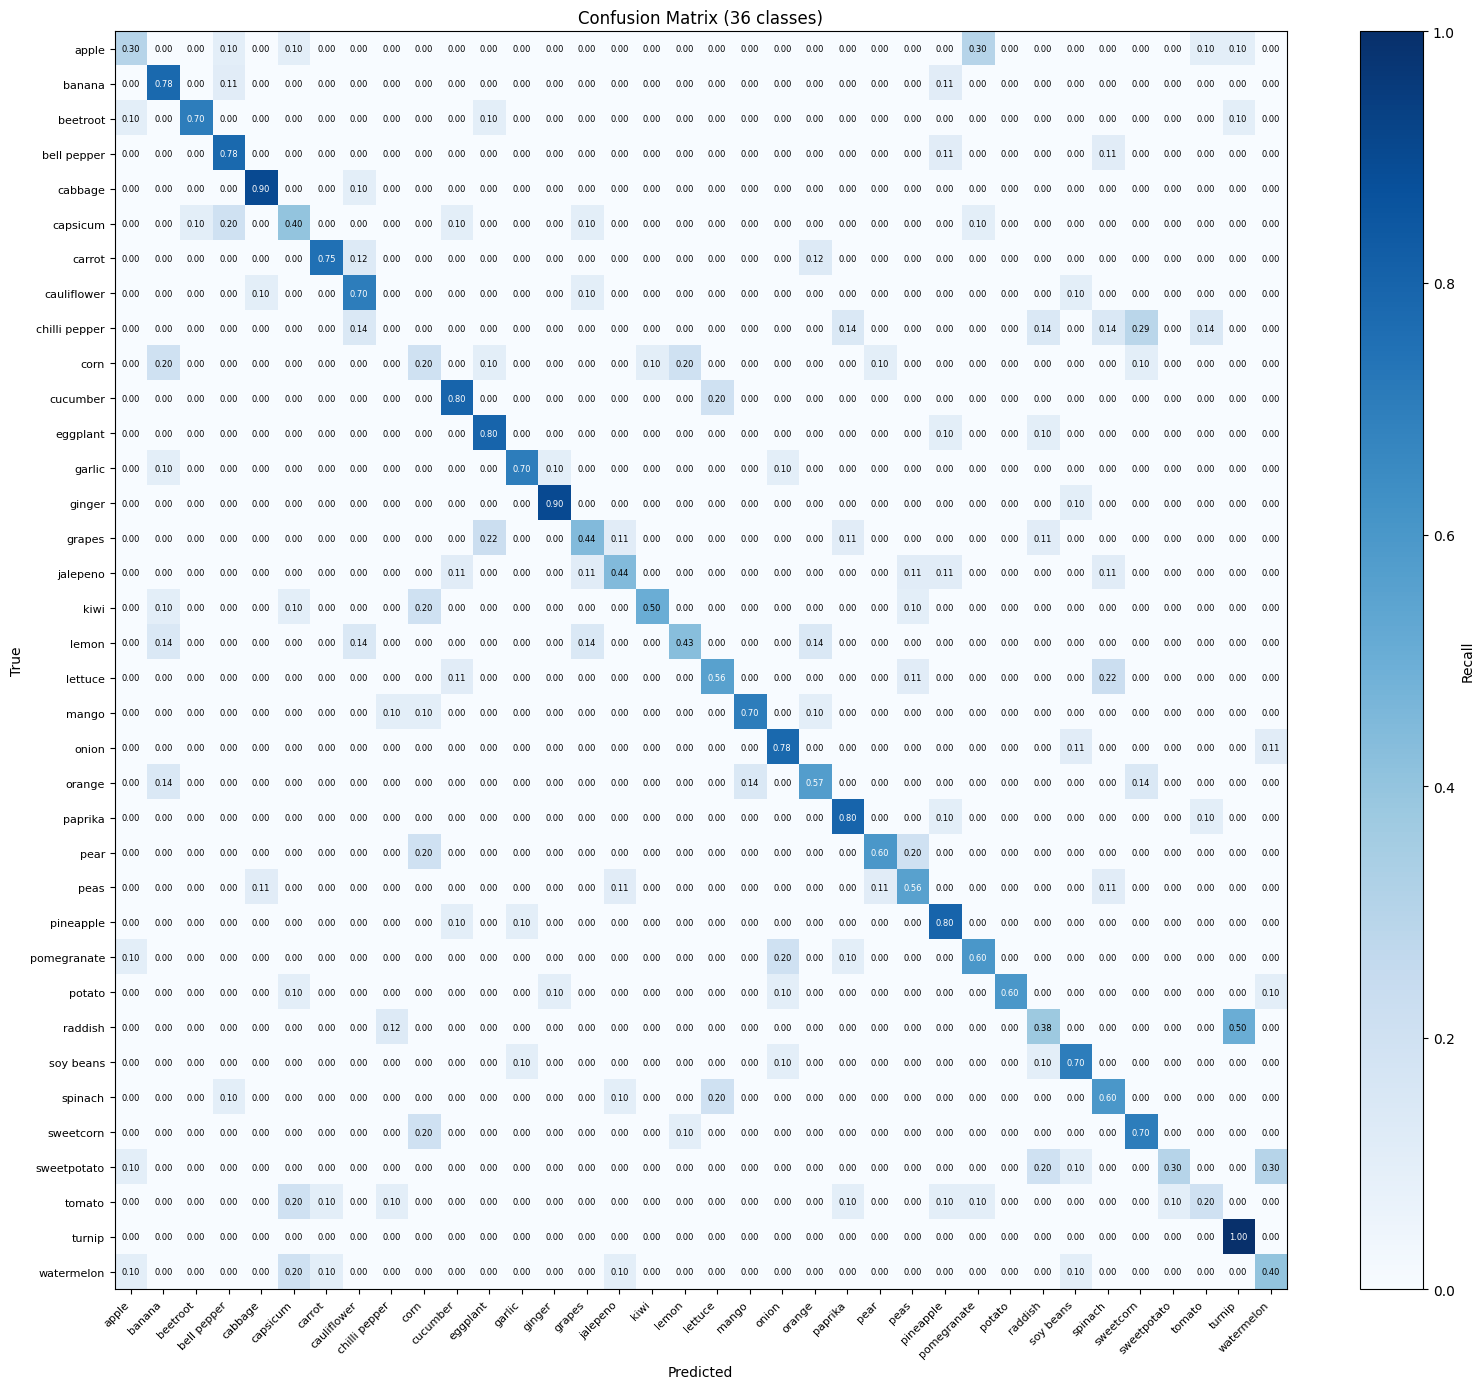

In [28]:
from src.utils import plot_confusion_matrix

fig, cm = plot_confusion_matrix(val_preds_mu.max(axis=1).indices, val_labels, val_ds.idx_to_class)

Some classes seem to be hard to classify, being confused ofted or all the time with another class, while for others, our linear classifier performs well. We have to note that the size of the validation set (340) is really small, so this result is almost sure to be heavily biased by the available samples (<10 per class on average).

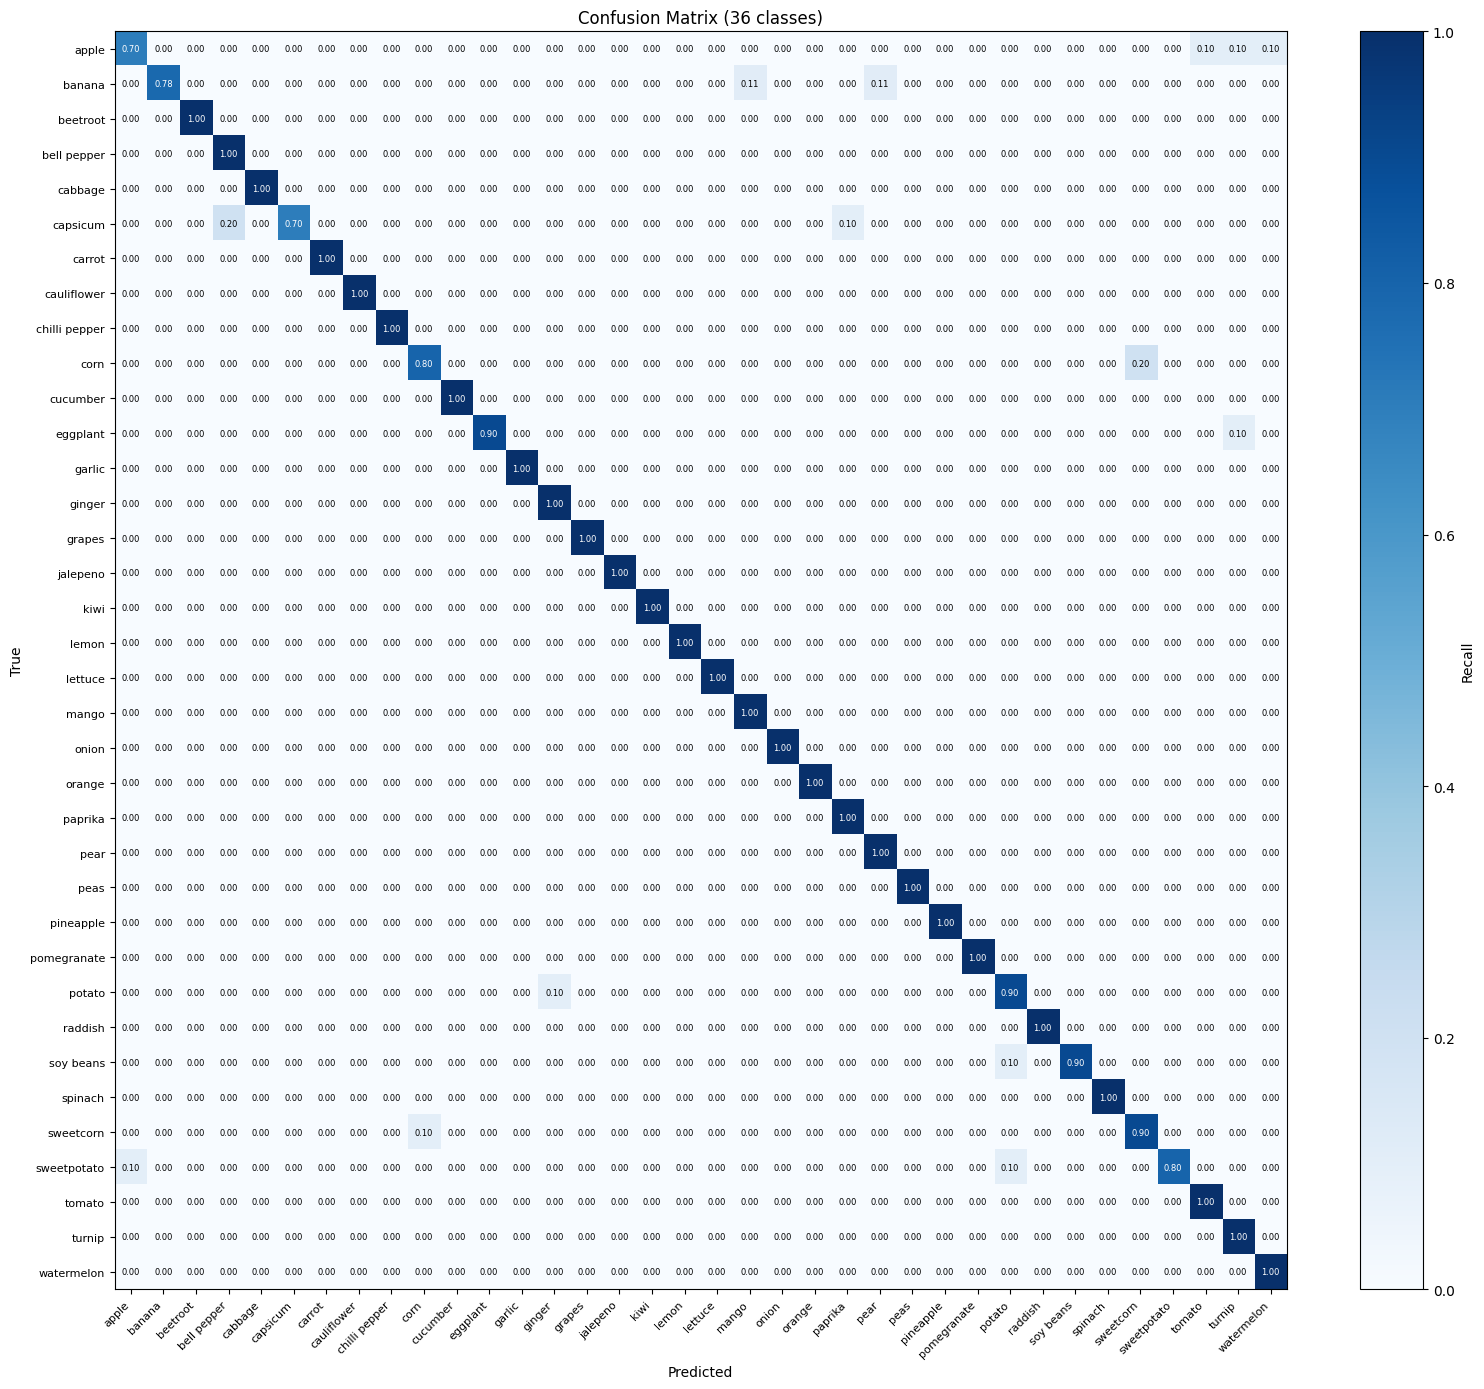

In [29]:
# Comparison to VisualClassifier
fig, cm = plot_confusion_matrix(preds_vc.cpu().max(axis=1).indices, labels, val_ds.idx_to_class)

The supervised CNN instead classifies the validation set almost perfectly.

## Robustness to noise

Similar to the lab, we will now inject some noise in the input images and see how much the representations learned by the VAE and are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [30]:
def inject_noise(imgs, noise_level=0.1):
    noise = torch.randn_like(imgs) * noise_level
    noisy_imgs = imgs + noise
    noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)  # ensure pixel values are in [0, 1]
    return noisy_imgs

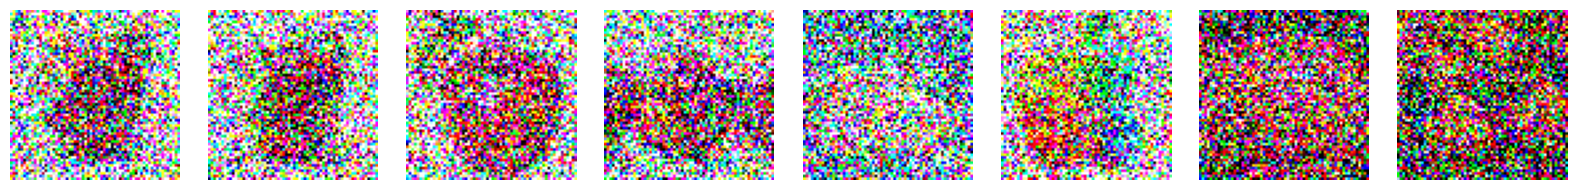

In [31]:
# Visualize some noisy samples
noisy_imgs = inject_noise(imgs, noise_level=1)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    img = noisy_imgs[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [32]:
# we modify the capture_all_activations function to accept noisy images
def capture_all_activations_noise(vae, dataset, device, noise_level=0.1):
    imgs = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)
    labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)

    imgs = inject_noise(imgs, noise_level=noise_level)

    capturer = IntermediateActivationCapture(vae)
    results = capturer.capture_inference(imgs, device=device)
    capturer.remove_hooks()
    return results, labels

In [33]:
# define a function to evaluate the linear model on noisy activations
def get_accuracy_at_noise_level(noise_level):
    val_cts_noise, val_labels = capture_all_activations_noise(vae, val_ds, device, noise_level=noise_level)
    
    preds_noisy = {
        layer: models[layer](val_cts_noise["encoder_activations"][layer].mean(dim=[2, 3]))
        for layer in layers
        }
    preds_noisy["latent_mean"] = models["latent_means"](val_cts_noise["encoder_activations"]["encoder_fc_mu"])

    preds_noisy["visual_classifier"] = vc(inject_noise(torch.stack([val_ds[i][0] for i in range(len(val_ds))], dim=0).to(device), noise_level=noise_level)).squeeze()

    accuracies = {layer: compute_accuracy(preds_noisy[layer], val_labels) for layer in preds_noisy.keys()}
    return accuracies
    


In [34]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = {}

accs = get_accuracy_at_noise_level(noise_level=noise_levels[0])
for layer, acc in accs.items():
    accuracies[layer] = [acc]

for i in noise_levels[1:]:
    accs = get_accuracy_at_noise_level(noise_level=i)
    for layer, acc in accs.items():
        accuracies[layer].append(acc)

Text(0.5, 1.0, 'Noise sensitivity on intermediate activations')

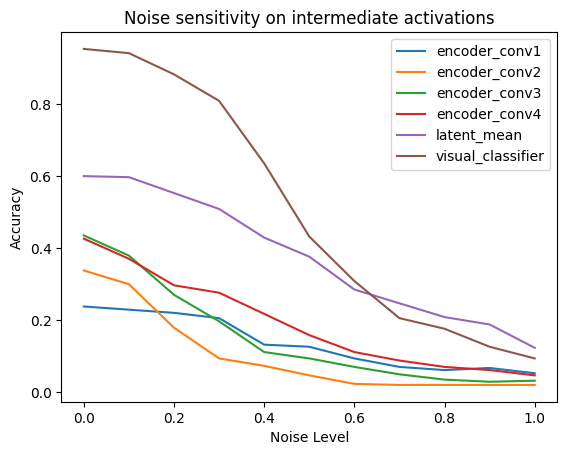

In [35]:
for accs in accuracies.values():
    plt.plot(noise_levels, accs)
plt.legend(accuracies.keys())
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Noise sensitivity on intermediate activations')

We observe good robustness to noise for low noise level and the latent mean and visual classifier models. The latent mean-based model is the most robust to noise, showing the smallest drop-off across the range, even outperforming the otherwise highly superior visual classifier for very high noise levels. This suggests that the regularization enforced by the latent space bottleneck and the the ELBO loss term is highly beneficial for noise resistance of the latent representation.

# Generative abilities
We shall now investigate the generative abilities of our VAE. In theory, samples belonging to the data distribution can be obtained simply by passing samples from the latent prior (in our case a 64-dimensional isotropic unit Gaussian) through the decoder. In practice, model training is usually not stable enough to allow for interpretable results from this method. Instead, it is recommended to use the dataset (or data subset) mean latent as a prior. That being said, let's try to generate some apples by sampling from the mean apple latent distribution.

In [36]:
# Well use the train ds to obtain a more representative sample.
# The first 59 samples are expected to be apples

# get one batch from the dataloader
apple_imgs = torch.stack([train_ds[i][0] for i in range(59)])
apple_targets = torch.tensor([train_ds[i][1] for i in range(59)])

apple_imgs.to('cpu')

with torch.no_grad():
    mu, logvar = vae.encoder(apple_imgs)

print(mu.shape)

torch.Size([59, 64])


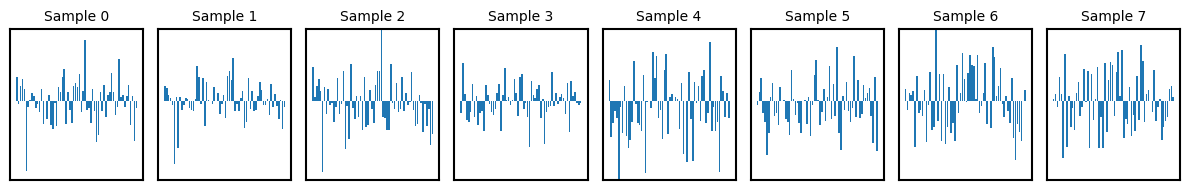

In [37]:
plot_latent_vectors(mu[:8])

The structure of "Apple" is not immediately apparent to the human eye, but the latents appear more similar than in the previous random batch.

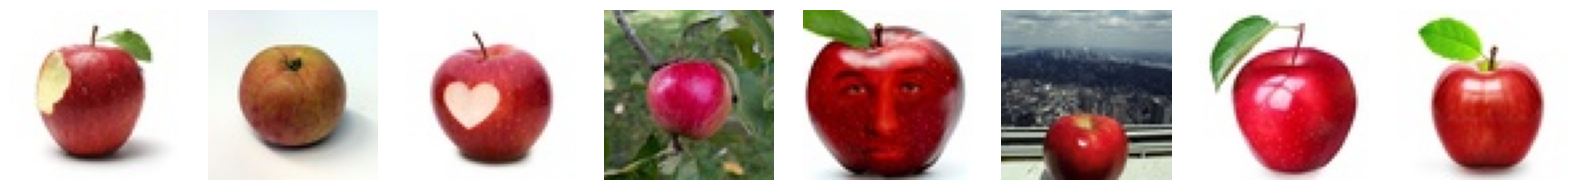

In [38]:
first_8 = apple_imgs[:8]

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    img = first_8[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [41]:
# obtain a "mean apple vector"
mu_apple = torch.mean(mu, dim=0)
logvar_apple = torch.mean(logvar, dim=0) * 0.1  # set small variance for more consistent samples

# obtain a batch of 8 samples from the "mean apple latent distribution"
with torch.no_grad():
    n = 8
    mu_exp = mu_apple.unsqueeze(0).expand(n, -1)        # [n, latent_dim]
    logvar_exp = logvar_apple.unsqueeze(0).expand(n, -1)    # [n, latent_dim]
    std = torch.exp(0.5 * logvar_exp)
    z_batch = mu_exp + torch.randn_like(std) * std 

# Obtain reconstructions
with torch.no_grad():
    reconstructed_imgs = vae.decoder(z_batch)

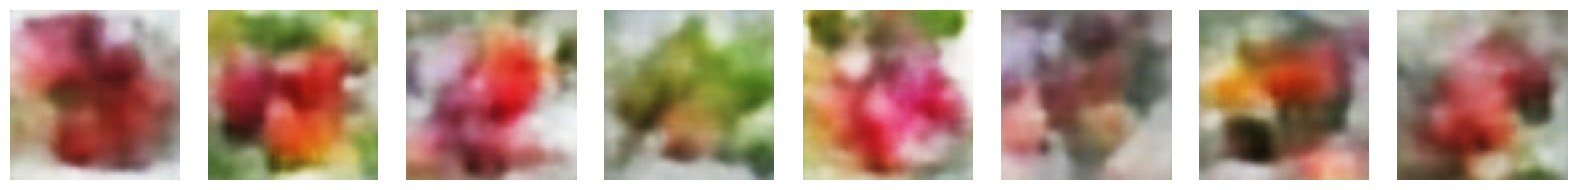

In [42]:
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    img = reconstructed_imgs[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

Conclusion: while the images mainly consist of the color spectrum that typically makes up apples, our model is clearly not powerful enought to create interpretable samples from mean latent values alone. We suspect that this is mainly due to the small size of our dataset. (We have played around a bit with different parametrizations on the latent mean sampling. The approach demonstrated here was among the best of our results.)

# Adversarial attacks

Finally, we want to perform adversarial attacks to our models, trying to force wrong classifications. Given the VAE as an encoder-decoder model that can also perform reconstructions, it would generally also be of interest to attack the decoder but we decide against it due to it being more difficult to quantitatively evaluate.

We decide on a simple attack using projected gradient decent (PGD), which aims to add perturbations to the image such that the classifer loss is maximized. 

$\max_{\delta}\{\mathcal{L}_{cls}(C(\mu(x+\delta)), y)\}$

We subsequently scale the obtained adversarial perturbations to achive a balance beween visual quality and adversarial power.

In [43]:
dataset = val_ds

imgs = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)
labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)

# We will calculate adversarial perturbations on the entire dataset at once.
delta = torch.zeros_like(imgs, requires_grad=True)

T = 40
epsilon = 0.1
alpha = epsilon / T

for t in range(T):
    # obtain latent means and logits
    mu, _ = vae.encoder(imgs + delta)
    logits = models["latent_means"](mu)

    # compute loss and gradients
    loss = torch.nn.CrossEntropyLoss()
    loss_value = loss(logits, labels)
    loss_value.backward()
    
    # update delta
    delta.data += alpha * delta.grad.sign()
    delta.data = torch.clamp(delta.data, -epsilon, epsilon)
    delta.grad.zero_()

Let's visualize some adversarial samples. We chose a magnitude of 0.2 on the delta to strike a balance between confusive power and visual quality.

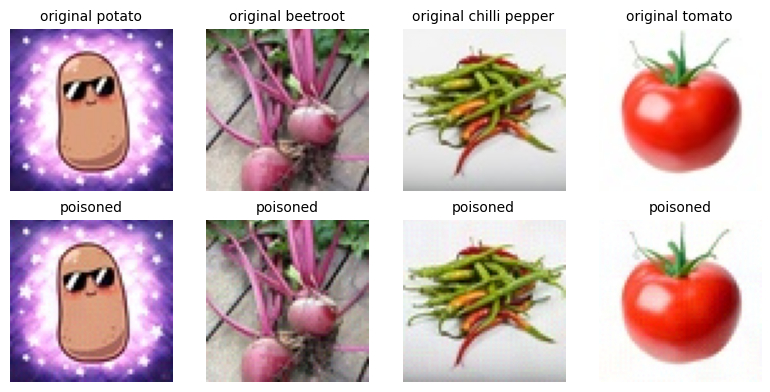

In [44]:
delta = delta.detach()

# Clamp the perturbed images to valid pixel range
poisoned_imgs = torch.clamp(imgs + delta*0.2, 0, 1)

random_indices = numpy_rng.choice(len(dataset), size=4, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for i, idx in zip(range(4), random_indices):
    axs[0][i].imshow(imgs[idx].permute(1, 2, 0).cpu().numpy())
    axs[0][i].axis('off')
    axs[0][i].set_title(f"original {dataset.idx_to_class[int(labels[idx].item())]}", fontsize=10)
    axs[1][i].imshow(poisoned_imgs[idx].permute(1, 2, 0).cpu().numpy())
    axs[1][i].axis('off')
    axs[1][i].set_title("poisoned", fontsize=10)
plt.tight_layout()
plt.show()

As can be seen, the poisened images are almost indistinguishable from the originals to the naked eye. However, they yield vastly different outcomes when we examin the classifier accuracy, powerfully demonstrating the effectiveness of the method:

In [45]:
with torch.no_grad():
    mu_poisoned, _ = vae.encoder(poisoned_imgs)
    mu_original, _ = vae.encoder(imgs)
    logits_poisoned = models["latent_means"](mu_poisoned)
    logits_original = models["latent_means"](mu_original)

print(f"Accuracy on original images: {compute_accuracy(logits_original, labels):.4f}")
print(f"Accuracy on poisoned images: {compute_accuracy(logits_poisoned, labels):.4f}")

Accuracy on original images: 0.6000
Accuracy on poisoned images: 0.0088


We now reuse our method from the noise attack to investigate the relationship between delta weight and the drop in accuracy across layers.

In [46]:
# we modify the capture_all_activations function for adversarial examples
def capture_all_activations_adversarial(vae, dataset, device, delta_scale=0.2):
    imgs = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)
    labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)

    imgs = torch.clamp(imgs + delta*delta_scale, 0, 1)

    capturer = IntermediateActivationCapture(vae)
    results = capturer.capture_inference(imgs, device=device)
    capturer.remove_hooks()
    return results, labels

# define a function to evaluate the linear models on adversarial activations
def get_accuracy_at_adversarial_level(delta_scale):
    val_cts_adversarial, val_labels = capture_all_activations_adversarial(vae, val_ds, device, delta_scale=delta_scale)
    
    preds_adversarial = {
        layer: models[layer](val_cts_adversarial["encoder_activations"][layer].mean(dim=[2, 3]))
        for layer in layers
        }
    preds_adversarial["latent_mean"] = models["latent_means"](val_cts_adversarial["encoder_activations"]["encoder_fc_mu"])

    # preds_adversarial["visual_classifier"] = vc(torch.clamp(torch.stack([val_ds[i][0] for i in range(len(val_ds))], dim=0).to(device) + delta*delta_scale, 0, 1)).squeeze()

    accuracies = {layer: compute_accuracy(preds_adversarial[layer], val_labels) for layer in preds_adversarial.keys()}
    return accuracies

In [47]:
delta_scales = np.linspace(0, 0.5, 11).tolist()
accuracies = {}

accs = get_accuracy_at_adversarial_level(delta_scale=delta_scales[0])
for layer, acc in accs.items():
    accuracies[layer] = [acc]

for i in delta_scales[1:]:
    accs = get_accuracy_at_adversarial_level(delta_scale=i)
    for layer, acc in accs.items():
        accuracies[layer].append(acc)

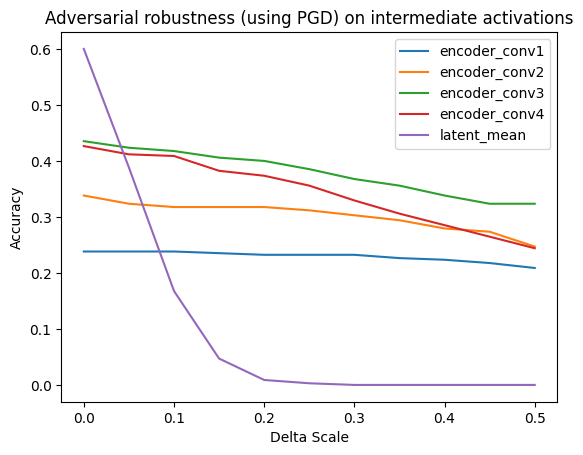

In [48]:
for accs in accuracies.values():
    plt.plot(delta_scales, accs)
plt.legend(accuracies.keys())
plt.xlabel('Delta Scale')
plt.ylabel('Accuracy')
plt.title('Adversarial robustness (using PGD) on intermediate activations')
plt.show()

We make the observation that the adversarial samples are extremely optimized to our latent mean representations themselves. Earlier layers in the encoder are impacted way less, with the impact growing with network depth. This is expected, as errors propagate through the neural network hierarchy. We also observe that 0.2 is indeed a good value to chose, as larger perturbations add little improvement to the confusive power.

# Conclusion

In this project, we provide a comprehensive exploration of how visual representations are learned and organized in deep neural networks along the example of a Variational Autoencoder (VAE) trained on the Fruits and Vegetables dataset.

## Key Findings

**Hierarchical Representation Learning**: Our linear readout experiments demonstrated that increasingly disentangled and discriminative representations emerge at deeper layers of the VAE encoder. Early layers capture low-level visual features with modest classification accuracy, while deeper layers encode semantic information that becomes progressively more separable. This hierarchical organization aligns with established principles of deep learning and validates the effectiveness of the VAE architecture for learning meaningful visual concepts.

**Feature Visualization & Internal Organization**: By analyzing encoder activations and examining learned feature distributions, we observed that the model develops highly structured internal representations. The spatial organization of class centroids in the latent space reveals natural clustering of semantically similar fruits and vegetables, suggesting that the VAE learns a meaningful continuous representation of fruit/vegetable concepts rather than memorizing class labels.

**Error Analysis through Psychometric Curves**: Noise-based psychometric curves revealed the robustness thresholds of the model's learned representations. Earlier layers show greater robustness to input perturbations, while deeper layers are more sensitive—a trade-off between low-level noise resistance and high-level semantic consistency that reflects the model's hierarchical processing strategy.

**Adversarial Robustness**: Our adversarial attacks using projected gradient descent demonstrated that the model exhibits layer-dependent vulnerability. Latent mean representations are highly sensitive to adversarial perturbations, while earlier encoder layers maintain classifier accuracy under significant adversarial stress. This pattern suggests that adversarial robustness and feature abstraction are related but distinct properties—deeper representations are more task-relevant but also more fragile.

**Architectural Validation**: The consistent performance across all experiments validates our choice of VAE architecture and training methodology. The model successfully learns both a generative model (for image reconstruction) and a discriminative representation (as evidenced by linear readout performance), demonstrating the effectiveness of the variational framework for discovering structured latent representations.

**Comparison with a Supervised Visual Model**: In comparison to a regular supervised CNN visual classifier using the same network architecture as our VAE, classifiers built on the CNN latents underperform against the visual classifier in all tested metrics except for resistence to extremely high noise. This suggests that, while powerful, the VAE paradigm isn't necessary campable of extracting the important features for classification without incoporating class information. We postulate this is also strongly influenced by the choice of our dataset.

## Implications and Future Work

The findings suggest several directions for future investigation:
- Exploring defense mechanisms against layer-specific adversarial vulnerabilities
- Investigating few-shot learning performance in the learned latent space
- Analyzing the role of the KL divergence term in discovering disentangled factors of variation
- Extending the analysis to larger-scale vision models and datasets to assess generalizability